In [37]:
from PIL import Image
import h5py
# import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
# import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.graph_objs as go
import plotly.express as px
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
# from scipy.stats import normpip install pillow
sys.path.insert(1, 'Osiris Temp\processing\python')
import rawFileReader
import csv
from itertools import groupby
import math
from scipy.optimize import curve_fit

import importlib
%matplotlib inline


<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Peter\AppData\Local\Temp\ipykernel_5348\1922071835.py:26: SyntaxWarning: invalid escape sequence '\p'
  sys.path.insert(1, 'Osiris Temp\processing\python')


In [48]:
class rpcHit():
    def __init__(self, channel, time, eta, event_num, rpc):
        self.rpc = rpc
        self.time = time
        self.channel = channel
        self.eta = eta
        self.event_num = event_num

    def __str__(self):
        return f"rpcHit(channel={self.channel}, time={self.time}, eta={self.eta}, event_num={self.event_num}, rpc={self.rpc})"

class rpcCoincidence():
    def __init__(self, event_num, time_bin, hits):
        self.event_num = event_num
        self.time_bin = time_bin
        self.hits = hits

    def __str__(self):
        return f"rpcCoincidence(event_num={self.event_num}, time_bin={self.time_bin}, hits={self.hits})"

class realigner():
    def __init__(self, fReader, max_process_event, adjustment = 0,
                interval = 100, monitor_factor = 3, window_size = 15,
                order = [[0,1], [1,2], [2,3], [3,4]], scDiffs = [], normDiffs = [],
                residEta = [] ,
                residPhi = [] , record_inserted_events = False,
                tof_correction = False, diffHists = [],
                dev_mode = True):
        self.events = []
        self.popt = [0, 0]
        self.temp_events = []
        self.event_chunk = []
        self.global_alignment = True
        self.globally_aligned_events = []
        self.globally_aligned_mets = [[] for _ in range(len(order))]
        self.interval = interval
        self.lastWasBad = False
        self.adjustment = adjustment
        self.order = order
        self.fReader = fReader
        self.updates = [0 for _ in range(len(order))]
        self.mets = [[] for _ in range(len(order))]
        self.offsetlist = [p for o in range(1, (4 + self.adjustment)) for p in (o, -o)]
        self.processedEvents = 0
        self.max_process_event = max_process_event
        self.insertion_list = [0 for _ in range(5)]
        self.debug_statement = dev_mode
        self.tdc3status = [True for _ in range(5)]
        self.lasttdc3Status = [True for _ in range(5)]  
        self.tdc_mets = [[] for _ in range(5)]
        self.monitor_factor = monitor_factor
        self.etaHits = [[] for rpc in range(6)]
        self.phiHits = [[] for rpc in range(6)]
        self.tol = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
        self.window_size = window_size
        self.successful_reconstructions = [[0 for i in range(len(self.tol))] for rpc in range(6)]
        self.tof_correction = tof_correction
        self.possible_reconstructions = [0 for rppc in range(6)]
        self.record_inserted_events = record_inserted_events
        self.totDiffs = {0:[[0 for etchan in range(32)] for phchan in range(64)],
                1:[[0 for etchan in range(32)] for phchan in range(64)], 
                2:[[0 for etchan in range(32)] for phchan in range(64)], 
                3:[[0 for etchan in range(32)] for phchan in range(64)],
                4:[[0 for etchan in range(32)] for phchan in range(64)],
                5:[[0 for etchan in range(32)] for phchan in range(64)]}
        self.nDiffs = {0:[[0 for etchan in range(32)] for phchan in range(64)],
                    1:[[0 for etchan in range(32)] for phchan in range(64)], 
                    2:[[0 for etchan in range(32)] for phchan in range(64)], 
                    3:[[0 for etchan in range(32)] for phchan in range(64)],
                    4:[[0 for etchan in range(32)] for phchan in range(64)],
                    5:[[0 for etchan in range(32)] for phchan in range(64)]}
        if diffHists == []:
            self.diffHists = {0:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc0etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        1:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc1etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        2:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc2etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        3:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc3etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        4:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc4etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        5:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc5etPhiDiff")) for etchan in range(32)] for phchan in range(64)]}
        else:
            self.diffHists = diffHists
        self.residEta = residEta
        self.residPhi = residPhi
        if scDiffs == []:
            self.scDiffs = [[0 for etchan in range(32)] for phchan in range(64)]
            self.normDiffs = [[0 for etchan in range(32)] for phchan in range(64)]
        else:
            self.scDiffs = scDiffs
            self.normDiffs = normDiffs
        
        self.chi2 = []
        self.event_of_interest = []
        
        self.event_hist = [0 for _ in range(5)]
        
    def get_aligned_events(self, mode = 'efficient', method = 'giveup', chi2_region = [0,100]):
        while self.processedEvents<self.max_process_event:
            if not self.fReader.readBlock():
                print("Bad Block Read")
                break
            if(self.fReader.hasEvents()):
                for event in self.fReader.getEvents():
                    self.events.append(event)
                    self.temp_events.append(event)
                    self.processedEvents = self.processedEvents+1
                    if self.processedEvents%self.interval==0 and self.processedEvents>0:
                        self.event_chunk = self.temp_events[-self.interval:]
                        aligned, realigned = self.doRealign(method = method)
                        self.check_alignment_status(aligned, realigned)
                        self.update_adjustment_window(realigned)

                        
                        # if self.global_alignment == True:
                            # self.readTDCTimeDiffs()
                            # self.populate_hits()
                            # cluster = self.make_cluster()
                            # self.reconstruct_and_extrapolate(cluster, chi2_region = chi2_region)
                        
                        if self.processedEvents%(self.monitor_factor * self.interval) == 0 and self.processedEvents>0:
                            self.monitor_tdc3_state()
                            self.temp_events.clear()
                            if mode != 'Full':
                                self.events.clear()
                                
                                
            self.etaHits = [[] for rpc in range(6)]
            self.phiHits = [[] for rpc in range(6)]
                
        self.outDict = {'totDiffs':self.totDiffs,
                    'nDiffs':self.nDiffs,
                    'diffHists':self.diffHists} 
        
    # def get_aligned_events_diffHist_done(self)
        
    def get_aligned_events_timing_compensated(self):
        while self.processedEvents<self.max_process_event:
            if not self.fReader.readBlock():
                print("Bad Block Read")
                break
            if(self.fReader.hasEvents()):
                for event in self.fReader.getEvents():
                    self.events.append(event)
                    self.temp_events.append(event)
                    self.processedEvents = self.processedEvents+1
                    if self.processedEvents%self.interval==0 and self.processedEvents>0:
                        self.event_chunk = self.temp_events[-self.interval:]
                        aligned, realigned = self.doRealign(method = 'giveup')
                        self.check_alignment_status(aligned, realigned)
                        self.update_adjustment_window(realigned)

                        
                        if self.global_alignment == True:
                            # print(f'global alignmend at {self.processedEvents}')
                            # self.readTDCTimeDiffs()
                            self.populate_hits()
                            self.apply_systematic_correction()
                            cluster = self.make_cluster()
                            self.reconstruct_and_extrapolate(cluster)
                        
                        if self.processedEvents%(self.monitor_factor * self.interval) == 0 and self.processedEvents>0:
                            self.monitor_tdc3_state()
                            self.temp_events.clear()
                            self.events.clear()
                                
                                
            self.etaHits = [[] for rpc in range(6)]
            self.phiHits = [[] for rpc in range(6)]

    def apply_systematic_correction(self):
        for rpc in range(6):
            for i, etahit in enumerate(self.etaHits[rpc]):
                self.etaHits[rpc][i].time -= self.residEta[rpc][etahit.channel]
            for j , phihit in enumerate(self.phiHits[rpc]):
                self.phiHits[rpc][j].time -= self.residPhi[rpc][phihit.channel]
            
                                
    def readTDCTimeDiffs(self):
        for event in self.event_chunk:
            rpcHits = tdcEventToRPCData(event,activeTDCs=[0,1,2,3,4])
            for rpc in [0,1,2,3,4,5]:
                minEtaHit = rpcHit(-1,1000,True, self.processedEvents, rpc)
                minPhiHit = rpcHit(-1,1000,False, self.processedEvents, rpc)
                for hit in rpcHits[rpc]:
                    if hit.time>150 and hit.time<300:
                        if hit.eta and hit.time<minEtaHit.time:
                            minEtaHit = hit
                        elif hit.time<minPhiHit.time and not hit.eta:
                            minPhiHit = hit
                if minEtaHit.channel>-0.5 and minPhiHit.channel>-0.5:
                    self.totDiffs[rpc][minPhiHit.channel][minEtaHit.channel] = self.totDiffs[rpc][minPhiHit.channel][minEtaHit.channel]+minEtaHit.time-minPhiHit.time
                    self.nDiffs[rpc][minPhiHit.channel][minEtaHit.channel] = self.nDiffs[rpc][minPhiHit.channel][minEtaHit.channel]+1
                    self.diffHists[rpc][minPhiHit.channel][minEtaHit.channel].fill(minEtaHit.time-minPhiHit.time)
    
    def make_cluster(self):
        coincident_hits = FindCoincidentHits(self.etaHits, self.phiHits, self.window_size, tof_correction=self.tof_correction)
        return cluster(coincident_hits)
    
    def reconstruct_and_extrapolate(self, dataset, chi2_region = [0, 100]):
        # Ensure RPC is a list, even if it's a single integer
        if self.tdc3status[3] == True:
            for rpc in range(6):
                for i, data in enumerate(dataset):
                        E_recon = reconstruct_timed_Chi2_ByRPC(data, 3, rpc)
                        if E_recon:

                            if len(E_recon[2]) >= 5:
                                if E_recon[4] > chi2_region[0] and E_recon[4] < chi2_region[1]:
                                    self.chi2.append(E_recon[4])
                                    self.event_of_interest.append(E_recon)
                                    # Adding this check to see if other 5 RPCs are in reconstructed event.
                                    # This is necessary to ensure the reconstructed path is accurate.

                                    muon_coords = does_muon_hit_RPC(E_recon[0], E_recon[1], rpc)

                                    if muon_coords:
                                        self.possible_reconstructions[rpc] += 1
                                        for idx, t in enumerate(self.tol):
                                            check = does_RPC_detect_muon(muon_coords, E_recon[7], t)
                                            if check:
                                                self.successful_reconstructions[rpc][idx] += 1
        
    def plot_efficiency(self, text = 'Efficiency vs Tolerance error state realign region qual == 0'):
        plt.figure(figsize=(10, 6))
        for RPC in range(6):
            if self.possible_reconstructions[RPC] == 0:
                efficiency = [0 for x in self.successful_reconstructions[RPC]]
            else:
                efficiency = [x / self.possible_reconstructions[RPC] for x in self.successful_reconstructions[RPC]]
            plt.plot(self.tol, efficiency, label=f'RPC {RPC}')

        plt.xlabel('Tolerance')
        plt.ylabel('Efficiency')
        plt.title(text)
        plt.legend()
        plt.grid(True)
        plt.show()
        print(self.possible_reconstructions)
           
    def populate_hits(self):
        skip_event = False
        for idx, event in enumerate(self.event_chunk):
            for tdc in range(5):
                if event.tdcEvents[tdc].qual != 0:
                    skip_event = True
                    break 
            if skip_event:
                continue 
            for tdc in range(5):
                for word in event.tdcEvents[tdc].words:
                    rpc, thisHit = tdcChanToRPCHit(word,tdc, self.processedEvents + idx)
                    if thisHit.eta:
                        self.etaHits[rpc].append(thisHit)

                    else:
                        self.phiHits[rpc].append(thisHit)
                      
    def plotTDCTimeDiffs(self, showplot = True, max_itr = 1):
        badPhi = {0:[],1:[61, 63],2:[31], 3:[0],4:[0,19], 5:[0, 31]}
        badEta = {0:[24,25,26,27,28,29,30,31],1:[11, 15],2:[],3:[31],4:[31], 5:[]}
        self.residEtaLatest = []
        self.residPhiLatest = []
        rpcNames = {0:"Triplet Low",1: "Triplet Mid", 2:"Triplet Top", 3:"Singlet",4:"Doublet Low",5:"Doublet Top"}
        evtCount = 0
        for rpc in [0,1,2,3,4,5]:
            slope = 0.173
            offSet = 13.2
            for ph in range(64):
                for et in range(32):
                    if sum(self.outDict['diffHists'][rpc][ph][et].counts())>0:
                        self.scDiffs[ph][et]=sum([thisVal*self.outDict['diffHists'][rpc][ph][et].axes.centers[0][idx] for idx, thisVal in enumerate(self.outDict['diffHists'][rpc][ph][et])])/sum(self.outDict['diffHists'][rpc][ph][et].counts())
                        self.normDiffs[ph][et]=self.scDiffs[ph][et]+slope*(ph-et)-offSet
            
            if showplot:
                fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
                etachannels = [x-0.5 for x in range(33)]
                phichannels = [x-0.5 for x in range(65)]
                etaHist = (self.scDiffs,np.array(phichannels),np.array(etachannels))
                zrange = [-5,30]
                thisHist = hep.hist2dplot(etaHist,norm=colors.Normalize(zrange[0],zrange[1]))
                thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
                plt.ylim(31.5,-0.5)
                plt.ylabel("Eta Channel")
                plt.xlabel("Phi Channel")
                ax.set_title(rpcNames[rpc])
                x_points = [-0.5, 64.5]
                y_points = [7.5, 15.5, 23.5]
                for y_point in y_points:
                    plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
                y_points = [-0.5, 31.5]
                x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
                for x_point in x_points:
                    plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
                plt.show()
                fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
                normHist = (self.normDiffs,np.array(phichannels),np.array(etachannels))
                zrange = [-4,4]
                thisHist = hep.hist2dplot(normHist,norm=colors.Normalize(zrange[0],zrange[1]))
                thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
                plt.ylim(31.5,-0.5)
                plt.ylabel("Eta Channel")
                plt.xlabel("Phi Channel")

                x_points = [-0.5, 64.5]
                y_points = [7.5, 15.5, 23.5]
                for y_point in y_points:
                    plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
                y_points = [-0.5, 31.5]
                x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
                for x_point in x_points:
                    plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
                ax.set_title(rpcNames[rpc]+", Propagation Time Corrected")
                plt.show()
            phTimes = [0 for chan in range(64)]
            etTimes = [0 for chan in range(32)]
            testSpeed = 0.173
            offSet = 13.46     
            itr = 0
            for phchan in range(64):
                for etchan in range(32):
                    if etchan not in badEta[rpc]:
                        phTimes[phchan] += self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet)
                phTimes[phchan] /= (32. - len(badEta[rpc]))

            itr += 1

            for phchan in range(64):
                for etchan in range(32):
                    if phchan not in badPhi[rpc]:
                        etTimes[etchan] += (self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet) - phTimes[phchan]) / (64. - len(badPhi[rpc]))

            itr += 1
            
            while itr <= max_itr:
                for phchan in range(64):
                    for etchan in range(32):
                        if etchan not in badEta[rpc]:
                            phTimes[phchan] += (self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet) + etTimes[etchan]) / (32. - len(badEta[rpc]))
                for phchan in range(64):
                    for etchan in range(32):
                        if phchan not in badPhi[rpc]:
                            etTimes[etchan] += (self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet) - phTimes[phchan]) / (64. - len(badPhi[rpc]))
                
                itr += 1
            self.residEtaLatest.append([time for time in etTimes])
            self.residPhiLatest.append([time for time in phTimes]) 

    def plotchi2(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.hist(self.chi2, bins=100, label='Chi2 Values')
        ax.legend()
        ax.set_title('Chi2 distribution')
        ax.set_ylabel('Number of events')
        ax.set_xlabel('Chi2 values')
        plt.show()
    
    def plottdcresidual(self):
        rpcNames = {0:"Triplet Low",1: "Triplet Mid", 2:"Triplet Top", 3:"Singlet",4:"Doublet Low",5:"Doublet Top"}
        fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
        phichannels = [x-0.5 for x in range(65)]

        for idx, rpc in enumerate([0,1,2,3,4,5]):
            plotPhiResids = self.residPhiLatest[idx].copy()
            plotPhiResids.append(plotPhiResids[-1])
            plt.step(phichannels,plotPhiResids,linewidth=3,label=rpcNames[rpc],where='post')
        yrange = ax.get_ylim()
        #ax.text(40, 0.8*yrange[1], "Slope: "+str(round(popt[0],3))+" ns/channel, Offset: "+str(round(popt[1],2))+" ns", fontsize=14,
        #               verticalalignment='top')
        ax.set_xlabel('$\phi$ Channel')
        ax.set_ylabel('Time Residual (ns)')
        # ax.set_ylim([-6,6])
        ax.set_xlim([-0.5,63.5])
        plt.legend()
        plt.show()
        fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
        etchannels = [x-0.5 for x in range(33)]
        for idx, rpc in enumerate([0,1,2,3,4,5]):
            plotEtaResids = self.residEtaLatest[idx].copy()
            plotEtaResids.append(plotEtaResids[-1])
            plt.step(etchannels,plotEtaResids,linewidth=3,label=rpcNames[rpc],where='post')
        yrange = ax.get_ylim()
        #ax.text(40, 0.8*yrange[1], "Slope: "+str(round(popt[0],3))+" ns/channel, Offset: "+str(round(popt[1],2))+" ns", fontsize=14,
        #               verticalalignment='top')
        ax.set_xlabel('$\eta$ Channel')
        ax.set_ylabel('Time Residual (ns)')
        # ax.set_ylim([-6,6])
        ax.set_xlim([-0.5,31.5])
        plt.legend()
        plt.show()               
                                            
    def plot_global_alignment_metric(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        for idx, item in enumerate(self.order):
            met = self.globally_aligned_mets[idx]
            i, j = item
            binsx = [x*self.interval for x in range(len(met))]
            ax.plot(binsx,met,label=f'TDC{i} and TDC{j}, offset 0')

        ax.set_xlim(0,self.max_process_event)
        ax.set_ylim(0,40)
        ax.legend()
        ax.set_title('Alignment graph')
        ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
        ax.set_xlabel('processed Event')
        plt.show()                      
                                                     
    def monitor_tdc3_state(self):
        for tdc in range(5):
            poor_time_count = 0
            good_time_count = 0
            for event in self.temp_events[-(self.monitor_factor * self.interval):]:
                words = event.tdcEvents[tdc].words
                times = [word & 0xfffff for word in words if (word >> 24) & 0x7f != 0]
                
                if times:
                    min_time = min(times)
                    if min_time > 300:
                        poor_time_count += 1
                    elif 200 < min_time < 300:
                        good_time_count += 1
                        
            if good_time_count == 0:
                self.tdc_mets[tdc].append(0)
                if self.lasttdc3Status[tdc] == True:
                    print(f'tdc{tdc} error state through bad time')
                    self.lasttdc3Status[tdc] = False
            else:
                ratio = poor_time_count / good_time_count
                self.tdc_mets[tdc].append(ratio)
                
                if ratio > 0.20:
                    self.tdc3status[tdc] = False
                    if self.lasttdc3Status[tdc] == True:
                        print(f'tdc{tdc} enters error state through metric')
                        self.lasttdc3Status[tdc] = False
                else:
                    self.tdc3status[tdc] = True
                    if self.lasttdc3Status[tdc] == False:
                        print(f'tdc{tdc} enters nominal state through metric')
                        self.lasttdc3Status[tdc] = True
                        buffer = self.fReader.reload_event_builder()
                        print(f'event builder reloaded, proof {buffer}')
            
    def plot_tdc_state_metric(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        for tdc in range(5):
            met = self.tdc_mets[tdc]
            binsx = [x*self.interval*self.monitor_factor for x in range(len(met))]
            ax.plot(binsx,met, label = f'tdc {tdc}')

        ax.set_xlim(0,self.max_process_event)
        ax.set_ylim(0,1)
        ax.legend()
        ax.set_title('TDC monitoring metric')
        ax.set_ylabel('bad time behavior / nominal time behavior')
        ax.set_xlabel('processed Event')
        plt.show()
        
    def plot_alignment_metric(self, plot_range=[0, 0]):
        fig, ax = plt.subplots(figsize=(10, 8))

        for idx, item in enumerate(self.order):
            if plot_range == [0, 0]:
                met = self.mets[idx]
                i, j = item
                binsx = [x * self.interval for x in range(len(met))]
                ax.plot(binsx, met, label=f'TDC{i} and TDC{j}, offset 0')
            else:
                start_idx = int(plot_range[0] / self.interval)
                end_idx = int(plot_range[1] / self.interval)
                if start_idx < 0 or end_idx > len(self.mets[idx]):
                    print(f"Invalid range for idx {idx}: start {start_idx}, end {end_idx}, length {len(self.mets[idx])}")
                    continue
                
                met = self.mets[idx][start_idx:end_idx]
                i, j = item
                binsx = [plot_range[0] + x * self.interval for x in range(len(met))]
                ax.plot(binsx, met, label=f'TDC{i} and TDC{j}, offset 0')

        if plot_range == [0, 0]:
            ax.set_xlim(0, self.max_process_event)
        else:
            ax.set_xlim(plot_range[0], plot_range[1])

        ax.set_ylim(0, 40)
        ax.legend()
        ax.set_title('Alignment graph')
        ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
        ax.set_xlabel('Processed Event')
        plt.show()

          
    def check_alignment_status(self, aligned, realigned):
        if not aligned and not realigned:
            self.lastWasBad = True
            self.global_alignment = False
        elif not aligned and realigned:
            self.lastWasBad = False
            self.global_alignment = False
        elif aligned and not realigned:
            self.lastWasBad = False
            self.global_alignment = True
        else:
            print(f'alignment error, realigned events already aligned, proicessed event {self.processedEvents}')
            
    def update_adjustment_window(self, realigned):
        if self.lastWasBad and not realigned:
            if self.adjustment < 25:
                self.adjustment += 1
        else:
            self.adjustment = 0
        
        self.offsetlist = [p for o in range(1, (4 + self.adjustment)) for p in (o, -o)]
                
    def calcAvgAlign(self,offSet=0, i = 1, j = 2, k = 0, l = 2, tdc1 =0, tdc0 = 1, processedEvents = 0, skipChans = []):
        mets = []
        for idx, event in enumerate(self.event_chunk):
            etaHits = [[] for rpc in range(6)]
            phiHits = [[] for rpc in range(6)]
            if (idx+abs(offSet))<len(self.event_chunk):
                if offSet<=0:
                    oneIdx = idx+abs(offSet)
                    twoIdx = idx
                else:
                    oneIdx = idx
                    twoIdx = idx+offSet
                for word in self.event_chunk[oneIdx].tdcEvents[tdc1].words:
                    rpc, thisHit = tdcChanToRPCHit(word,tdc1, processedEvents + idx)
                    if thisHit.eta:
                        etaHits[rpc].append(thisHit)

                    else:
                        phiHits[rpc].append(thisHit)
                for word in self.event_chunk[twoIdx].tdcEvents[tdc0].words:
                    rpc, thisHit = tdcChanToRPCHit(word,tdc0, processedEvents + idx)
                    if thisHit.eta:
                        etaHits[rpc].append(thisHit)

                    else:
                        phiHits[rpc].append(thisHit)     
                if i != -1:  
                    etOff = testAlign(etaHits[i],etaHits[j], skipChans = skipChans)
                    phOff = testAlign(phiHits[k],phiHits[l], skipChans = skipChans)
                    if etOff>=0 and phOff>=0:
                        mets.append(math.sqrt(etOff*etOff+phOff*phOff))
                else:
                    phOff = testAlign(phiHits[k],phiHits[l], skipChans = skipChans)
                    if phOff>=0:
                        mets.append(math.sqrt(phOff*phOff))
        if len(mets)>0:
            return sum(mets)/len(mets)
        else:
            return 100
 
    def doRealign(self, skipChans=[0], method = 'giveup'):
        aligned = True
        realigned = False
        for idx, item in enumerate(self.order):
            i, j = item
            x, y, l, m = find_tdc_alignment_metric(i, j)
            alignMet = self.calcAvgAlign(offSet=0, i=x, j=y, k=l, l=m, tdc1=i, tdc0=j, processedEvents=self.processedEvents, skipChans=skipChans)
            self.mets[idx].append(alignMet)
            if alignMet > 15 and alignMet < 100:
                aligned = False
                if self.tdc3status[3] == False and method == 'giveup':
                    continue
                for testOffset in self.offsetlist:
                    testAlignMet = self.calcAvgAlign(offSet=testOffset, i=x, j=y, k=l, l=m, tdc1=i, tdc0=j, processedEvents=self.processedEvents, skipChans=skipChans)
                    if testAlignMet < 15:
                        self.updates[idx] += (testOffset)
                        realigned = True
                        break
            else:
                self.globally_aligned_mets[idx].append(alignMet)
                # self.globally_aligned_events.extend(self.event_chunk)
        self.ConstructEventInsertionList()
        if not all(x == 0 for x in self.insertion_list):
            self.InsertFakeEvents()

        return aligned, realigned
    
    def ConstructEventInsertionList(self):
        for idx, update in enumerate(self.updates):
            i, j = self.order[idx]
            self.insertion_list[j] += (self.insertion_list[i] - update)
        min_value = min(self.insertion_list)
        if min_value < 0:
            addition = abs(min_value)
        else:
            addition = 0
        self.insertion_list = [x + addition for x in self.insertion_list]
    
    def InsertFakeEvents(self):
        for tdc, insertion in enumerate(self.insertion_list):
            for fakeEvent in range(insertion):
                self.fReader.evtBuilder.insertFakeEvent(tdc = tdc)
        if self.debug_statement == True:
            print(f'New alignment, Event number {self.processedEvents}, insertions {self.insertion_list}, updates {self.updates}')
            
        
        if self.record_inserted_events:
            self.event_hist = [x + y for x, y in zip(self.event_hist, self.insertion_list)]

        self.insertion_list = [0 for _ in range(5)]
        self.updates = [0 for _ in range(len(self.order))]
    
    def curve_fit_tof(self):
        excludedEta = [31]
        excludedPhi = [19]
        fitPhChan = [0.5+chan for chan in range(64)]
        fitEtChan = [0.5+chan for chan in range(32)]
        fitDiffs = [row[:] for row in self.scDiffs]

        for phchan in range(64):
            for etchan in range(32):
                if phchan in excludedPhi:
                    fitDiffs[phchan][etchan] = self.scDiffs[phchan+1][etchan]
                if etchan in excludedEta:
                    fitDiffs[phchan].pop(etchan)

        for etChan in excludedEta:
            fitEtChan.pop(etChan)

        def plane(xy,a,b):
            x, y = xy
            return (a*(x-y)+b).ravel()

        x, y = np.meshgrid(fitEtChan, fitPhChan)

        popt,pcov = curve_fit(plane,(x,y),np.array(fitDiffs).ravel(),p0=[0.175,13])
        print(popt[0],popt[1])
        self.popt = popt
           
def calc_efficiency_RPC(dataset, RPC, tol):
    # Ensure RPC is a list, even if it's a single integer
    RPC_excluded = RPC

    # events = filter_events_by_RPC(dataset, 2, 5, RPC_excluded)
    datas = dataset

    possible_reconstructions = 0
    successful_reconstructions = [0 for i in range(len(tol))]

    for i, data in enumerate(datas):

        # print(f"Event index {i}")

        E_recon = reconstruct_timed_Chi2_ByRPC(data, 3, RPC_excluded)

        if E_recon:
            if len(E_recon[2]) >= 5:
                # Adding this check to see if other 5 RPCs are in reconstructed event.
                # This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0], E_recon[1], RPC_excluded)

                if muon_coords:
                    possible_reconstructions += 1
                    for idx, t in enumerate(tol):
                        check = does_RPC_detect_muon(muon_coords, E_recon[7], t)
                        if check:
                            successful_reconstructions[idx] += 1
    if possible_reconstructions == 0:
        return -1
    return [possible_reconstructions, successful_reconstructions]
def tdcChanToRPCHit(word, tdc, event_num):
        tdcChannel = (word >> 24) & 0x7f
        tdcHitTime = word & 0xfffff
        eta = False
        rpcChan = -1
        if tdc == 0:
            if tdcChannel < 32:
                rpcChan = tdcChannel
                eta = True
                rpc = 0
            elif tdcChannel < 96:
                rpcChan = tdcChannel - 32
                eta = False
                rpc = 0
            else:
                rpcChan = tdcChannel - 96
                eta = True
                rpc = 1
        elif tdc == 1:
            if tdcChannel < 64:
                rpcChan = tdcChannel
                eta = False
                rpc = 1
            elif tdcChannel < 96:
                rpcChan = tdcChannel - 64
                eta = True
                rpc = 2
            else:
                rpcChan = tdcChannel - 96
                eta = False
                rpc = 2
        elif tdc == 2:
            if tdcChannel < 32:
                rpcChan = tdcChannel + 32
                eta = False
                rpc = 2
            elif tdcChannel < 64:
                rpcChan = tdcChannel - 32
                eta = True
                rpc = 3
            elif tdcChannel < 128:
                rpcChan = tdcChannel - 64
                eta = False
                rpc = 3
        elif tdc == 3:
            if tdcChannel < 32:
                rpcChan = tdcChannel
                eta = True
                rpc = 4
            elif tdcChannel < 96:
                rpcChan = tdcChannel - 32
                eta = False
                rpc = 4
            else:
                rpcChan = tdcChannel - 96
                eta = True
                rpc = 5
        elif tdc == 4:
            rpcChan = tdcChannel
            eta = False
            rpc = 5
        return rpc, rpcHit(rpcChan, tdcHitTime * 0.8, eta, event_num, rpc)
def Unpack_event(eventList, processedEvents):
    allEtaHits = [[] for rpc in range(6)]
    allPhiHits = [[] for rpc in range(6)]
    for event_num, event in enumerate(eventList):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        for i in range(5):
            for word in event.tdcEvents[i].words:
                rpc, thisHit = tdcChanToRPCHit(word, i, processedEvents - len(eventList) + event_num + 1)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
        for rpc in range(6):
            allEtaHits[rpc].extend(etaHits[rpc])
            allPhiHits[rpc].extend(phiHits[rpc])
    return allEtaHits, allPhiHits
def FindCoincidentHits(etaHits, phiHits, time_window, tof_correction = False):
    channels = []
    
    # Combine etaHits and phiHits from all RPCs
    for RPC in range(6):
        channels += [hit for hit in etaHits[RPC] if 150 <= hit.time <= 300]
        channels += [hit for hit in phiHits[RPC] if 150 <= hit.time <= 300]

    # Sort events by event number and then by time within each event
    event_sorted = sorted(channels, key=lambda rpcHit: (rpcHit.event_num, rpcHit.time))
    
    # Group by event number
    grouped_and_sorted = {key: list(group) 
                          for key, group in groupby(event_sorted, lambda rpcHit: rpcHit.event_num)}
    
    coincident_hits = []

    for event_num, hits in grouped_and_sorted.items():
        temp_hits = []

        for i in range(len(hits) - 1):
            if tof_correction:
                if hits[i].eta:
                    correction = find_tof_time(hits[i], hits[i+1])
                else:
                    correction = find_tof_time(hits[i+1], hits[i])
            else:
                correction = 0
            
            if abs(hits[i+1].time - hits[i].time + correction) <= time_window:
                temp_hits.append(hits[i])
                temp_hits.append(hits[i+1])

        if temp_hits:
            # Remove duplicates and sort by time
            unique_hits = { (hit.channel, hit.time, hit.eta, hit.event_num, hit.rpc): hit for hit in temp_hits }.values()
            time_bin = min(hit.time for hit in unique_hits)
            
            coincident_hits.append([
                event_num,
                time_bin,
                [[hit.rpc, hit.channel, hit.time, hit.eta] for hit in unique_hits]
            ])


    return coincident_hits
def cluster(coincident_hits):
    coincident_hits_clustered = []

    for coincidence_event in coincident_hits:

        coincident_event_clustered = [coincidence_event[0], coincidence_event[1], []]

        hit_locations = coincidence_event[2]
        phi_locations = [x for x in hit_locations if x[3] == False]
        eta_locations = [x for x in hit_locations if x[3] == True]

        phi_locations = sorted(phi_locations, key=lambda x: x[1])
        eta_locations = sorted(eta_locations, key=lambda x: x[1])

        for RPC in range(6):
            rpc_phi_clusters = []
            rpc_eta_clusters = []

            i = 0
            for index, hit in enumerate([x for x in phi_locations if x[0] == RPC]):
                if index == 0:
                    previous_element = hit[1]
                    rpc_phi_clusters.append([hit])
                else:
                    if abs(hit[1] - previous_element) > 1:
                        rpc_phi_clusters.append([hit])
                        i += 1
                    else:
                        rpc_phi_clusters[i].append(hit)
                    previous_element = hit[1]

            j = 0
            for index, hit in enumerate([x for x in eta_locations if x[0] == RPC]):
                if index == 0:
                    previous_element = hit[1]
                    rpc_eta_clusters.append([hit])
                else:
                    if abs(hit[1] - previous_element) > 1:
                        rpc_eta_clusters.append([hit])
                        j += 1
                    else:
                        rpc_eta_clusters[j].append(hit)
                    previous_element = hit[1]

            rpc_combined = [rpc_phi_clusters, rpc_eta_clusters]

            coincident_event_clustered[2].append(rpc_combined)

        coincident_hits_clustered.append(coincident_event_clustered)

    return coincident_hits_clustered

def find_tof_time(eta, phi):
    slope = 0.173
    offSet = 13.2
    if (len(set([eta.eta, phi.eta])) == 1):
        return 0
    else:
        return slope*(phi.channel-eta.channel)-offSet

def check_event_attributes(event,min_chamber_number,min_RPC_number):
    #Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    for RPC in range(6):
        if RPC<3:
            #Checking triplet layer.
            if event[2][RPC][0] and event[2][RPC][1]:
                #Reqiure       phi^              and               eta^       strips to go off
                RPC_counter+=1 
                #If RPC has two eta and phi strips going off then consider it "hit"
                if not condition_1:
                    #Count triplet chamber being hit.
                    chamber_counter+=1
                    condition_1 = True
        elif RPC == 3:
            #Singlet layer
            if event[2][RPC][0] and event[2][RPC][1]:
                RPC_counter+=1
                if not condition_2:
                    chamber_counter+=1
                    condition_2 = True
        else:
            #Doublet layer
            if event[2][RPC][0] and event[2][RPC][1]:
                RPC_counter+=1
                if not condition_3:
                    chamber_counter+=1
                    condition_3 = True

    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number
def filter_events(events,min_chamber_number,min_RPC_number):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes(event,min_chamber_number,min_RPC_number):
            filtered_events.append(event)

    print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events
def generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length=None, exact_length=False, combinations=None, hit_coords=None, depth=0):
    if combinations is None:
        combinations = []
    if hit_coords is None:
        hit_coords = []
    if max_length is None:
        max_length = len(coords)

    # Base case: If we've reached the end of the coords or the length condition is met
    if depth == len(coords) or len(hit_coords) == max_length:
        if not exact_length or len(hit_coords) == max_length:
            combinations.append(hit_coords.copy())
        return combinations

    # Extract x and y values for the current depth
    x_values = coords[depth][0]
    y_values = coords[depth][1]

    # If there are no x or y values at this depth, move to the next depth
    if not x_values or not y_values:
        return generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length, exact_length, combinations, hit_coords, depth + 1)

    # Iterate over all combinations of x and y values
    for x in x_values:
        for y in y_values:
            if x is not None and y is not None and isinstance(x[0], (int, float)) and isinstance(y[0], (int, float)):
                hit_coords.append([x, y, RPC_heights[depth]])
                generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length, exact_length, combinations, hit_coords, depth + 1)
                hit_coords.pop()

    return combinations
def extract_DT_DZ_Chi2(coords):

    #coords = [[[x0,var,time],[y0,var],z0],[[x1,var,time],[y1,var],z1],...,[[x5,var,time],[y5,var],z5]]

    times = [[RPC,x[0][2]] for RPC, x in enumerate(coords) if isinstance(x[2], (float, int))]

    #Should already be sorted, but just in case.
    #Sort times by RPC, with RPC at lowest height at first entry.

    if len(times) > 1:

        times_sorted = sorted(times, key=lambda x: x[0])

        #print(times_sorted)

        dT = times_sorted[-1][1]-times_sorted[0][1]
        #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
        #Vice-versa for dT < 0 

        RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

        first_RPC = times_sorted[0][0]
        last_RPC = times_sorted[-1][0]

        dZ = RPC_heights[last_RPC] - RPC_heights[first_RPC]
    
        return dT, dZ
    else:
        pass
def fit_event_chi2(coordinates_with_error):
    #Coordinates = [[[x0,var,time],[y0,var],z0],[[x1,var,time],[y1,var],z1],...,[[x5,var,time],[y5,var],z5]]
    #Z coordinate given by height of relevant RPC.
    #Using SVD

    # Calculate dT for event, in ns
    dT, dZ = extract_DT_DZ_Chi2(coordinates_with_error)
    
    coordinates = []

    for coords in coordinates_with_error:
        coordinates.append([coords[0][0],coords[1][0],coords[2]])

    centroid = np.mean(coordinates, axis=0)
    subtracted = coordinates-centroid

    # performing SVD
    _, _, V = np.linalg.svd(subtracted)
    
    # find the direction vector (which is the right singular vector corresponding to the largest singular value)
    direction = V[0, :]

    # A line is defined by the average and its direction
    p0 = centroid
    d = direction

    #Work out Chi2. Minimise this to find best fit (from possible combos)

    Chi2 = 0

    i = 0 

    for point in coordinates_with_error:
        
        i+=2
        
        z = point[2]
        x = point[0][0]
        y = point[1][0]
        x_var = point[0][1]
        y_var = point[1][1]

        z_0 = centroid[2]

        # t = (z-z_0)/d_z

        t = (z-z_0)/d[2]

        # Find expected (x,y) coordinates at that height.

        x_traj = centroid[0] + t*d[0]
        y_traj = centroid[1] + t*d[1]

        Chi2_x = (x-x_traj)**2 / x_var
        Chi2_y = (y-y_traj)**2 / y_var

        Chi2+= Chi2_x
        Chi2+= Chi2_y

    # i is number of fitted points. There are 4 fitted paramters, 2 for each x and y. 
    doF = i - 4

    Chi2 = Chi2/ doF

    return p0, d, Chi2, coordinates, dT, dZ
def extract_coords_timed_Chi2(event,max_cluster_size):

    #This function converts spatially clusters in RPCs into x and y coordinates (z given by RPC number)
    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm
    
    coords = []

    for RPC in range(6):
        
        x_clusters = [x for x in event[2][RPC][0] if len(x)<=max_cluster_size] #phi direction
        y_clusters = [y for y in event[2][RPC][1] if len(y)<=max_cluster_size] #eta direction

        #Finding size of largest cluster, consider coordinates bad if largest cluster is larger than 6.
        x_clusters_lengths = [len(x) for x in event[2][RPC][0]]
        y_clusters_lengths = [len(y) for y in event[2][RPC][1]]

        max_length = max(max(x_clusters_lengths, default=0), max(y_clusters_lengths, default=0))

        x_coords = []
        y_coords = []
        
        for x_cluster in x_clusters:
            # Extract phi channels and times from the cluster
            phi_channels = [x[1] for x in x_cluster]
            phi_times = [t[2] for t in x_cluster]

            # Convert the channel number into a measurement along the RPC
            x_values = [(phi_channel + 0.5) * distance_per_phi_channel for phi_channel in phi_channels]

            # Variance in x coord
            x_var = (1 * distance_per_phi_channel) ** 2 / 12

            # Find the index of the minimum time
            min_time_index = phi_times.index(min(phi_times))

            # Append the x value corresponding to the minimum time
            x_coords.append([x_values[min_time_index], x_var, min(phi_times)])

        for y_cluster in y_clusters:
            #y_cluster = [[RPC,CHANNEL,TIME,'eta'],...]
            eta_channels_corrected = [31-y[1] for y in y_cluster] #corrected for labelling from 0 to 31.
            eta_times = [t[2] for t in y_cluster]
            y_values = [(channel_num+0.5)*distance_per_eta_channel for channel_num in eta_channels_corrected]
            
            y_var = (1*distance_per_eta_channel)**2 /12
            
            # Find the index of the minimum time
            min_time_index = eta_times.index(min(eta_times))
            
            y_coords.append([y_values[min_time_index],y_var,min(eta_times)])

        if x_coords and y_coords:

            coords.append([x_coords, y_coords])

        else:
            coords.append([[],[],"N"])

    #[x_coords] = [[x,err_x,x_time],...]
    
    #RPC_coords = [x_coords,y_coords]

    #coords = [[RPC1_coords],[RPC2_coords],[RPC3_coords],...]
    return coords
def reconstruct_timed_Chi2_ByRPC(event,max_cluster_size, RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.


    #Extract x and y coords of cluster in event
    coords = extract_coords_timed_Chi2(event,max_cluster_size)

     # Filter out coords of RPC under test 

    test_coords = coords[RPC_excluded]

    coords[RPC_excluded] = [[],[],"N"] 
    
    # if RPC_excluded[1] < 6:
    #     coords[RPC_excluded[1]] = [[],[],"N"] 

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    if cross_chamberness < 2:
        #print("Failed to reconstruct, too few chambers")
        return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?

    if dT != np.inf:

        if dT > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ, test_coords

    else:
        #print("Failed to reconstruct, Chi2 too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
def check_event_attributes_by_RPC(event, min_chamber_number, min_RPC_number, RPC_excluded):
    # Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.
    # The user selects an RPC to exclude from the filter.
    # e.g. say we want to exclude RPC 4 and the user selects a min_RPC_number of 4.
    # The function will check if the event has at least 4 RPCs hit.

    # USING ONLY ETA FILTER HERE SINCE THIS IS WHAT TRIGGERS THE CHANNEL!

    # event = ['Event x', TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    # Check if any of the excluded RPCs have ETA clusters
    # for excluded_RPC in RPC_excluded:
    if event[2][RPC_excluded][1] != []:
        return False

    for RPC in range(6):
        if RPC != RPC_excluded:
            # If the RPC is not excluded, we check for ETA clusters.
            if event[2][RPC][1]:
                RPC_counter += 1

                if RPC < 3:
                    # Checking triplet layer.
                    if not condition_1:
                        chamber_counter += 1
                        condition_1 = True
                elif RPC == 3:
                    # Checking singlet layer.
                    if not condition_2:
                        chamber_counter += 1
                        condition_2 = True
                else:
                    # Checking doublet layer.
                    if not condition_3:
                        chamber_counter += 1
                        condition_3 = True

    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number
def filter_events_by_RPC(events,min_chamber_number,min_RPC_number,RPC_excluded):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
            filtered_events.append(event)
        else :
            event[2][RPC_excluded][1] = []
            event[2][RPC_excluded][0] = []
            filtered_events.append(event)
                

   # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events
def reconstruct_timed_Chi2(event,max_cluster_size, max_length=None, exact_length=False):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = extract_coords_timed_Chi2(event,max_cluster_size)

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    #NEED TO CHECK IF STILL CROSS CHAMBER! 

    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    # print(coords[0])
    # print(coords[1])
    # print(coords[2])
    # print(coords[3])
    # print(coords[4])
    # print(coords[5])
    # print(cross_chamberness)

    if cross_chamberness < 2:
        #print("Failed to reconstruct, too few chambers")
        return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights, max_length=max_length, exact_length=exact_length)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT != np.inf:

        if dT > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ

        else:
            #print("Failed to reconstruct, Chi2 too large")
            #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
            return None
def extract_angles_phi_eta_timed_DZ(filtered_events, max_length=None, exact_length=False):

    #Input is filtered_events, output of ANT.filter_events() function

    angles_eta = []
    angles_phi = []
    delta_times = []
    dZ = []
    chi2_values = []

    for i,filtered_event in enumerate(filtered_events):

        # print(f"Index= {i}") 
        
        result = reconstruct_timed_Chi2(filtered_event,3, max_length=max_length, exact_length=exact_length)

        if result is not None:

            delta_times.append(result[5])

            chi2_values.append(result[4])

            # if abs(result[5])>40:
            #     print(f"Index of abnormal event= {i}")
            # #Only save angles that actually were reconstructed well

            dZ.append(result[6])
            
            # a.b = |a||b|cos(x)

            #eta angle. 
            #work out the projection of the direction vector in the plane.
            
            v_parr_eta = np.array([0,result[1][1],result[1][2]])

            theta_eta = np.arccos(np.dot(v_parr_eta,[0,0,1]) / np.linalg.norm(v_parr_eta))

            if theta_eta > np.pi / 2:
                theta_eta= np.pi - theta_eta
            
            if v_parr_eta[1] > 0:
                theta_eta*=-1

            angles_eta.append(theta_eta)

            # Phi angles
            #work out the projection of the direction vector in the plane.
            
            v_parr_phi = np.array([result[1][0],0,result[1][2]])

            theta_phi = np.arccos(np.dot(v_parr_phi,[0,0,1]) / np.linalg.norm(v_parr_phi))

            if theta_phi > np.pi / 2:
                theta_phi= np.pi - theta_phi
            
            if v_parr_phi[0] < 0:
                theta_phi*=-1

            angles_phi.append(theta_phi)

    return angles_eta, angles_phi, delta_times, dZ, chi2_values
def interactive_muon_plot(centroid,d,event_coords):
    #Coefficients = [a,b,c]
    #event_coords = [[x0,y0,z0],[x1,y1,z1],...,[x5,y5,z5]]

    # Generate line coordinates
    t_values = np.linspace(-150, 150, 100)
    line_coordinates = centroid.reshape(-1, 1) + d.reshape(-1, 1) * t_values.reshape(1, -1)

    x_coords = [x[0] for x in event_coords]
    y_coords = [y[1] for y in event_coords]
    z_coords = [z[2] for z in event_coords]


    RPC_origins = [[0,0,0],[0,0,1.2],[0,0,2.4],[0,0,61.2],[0,0,121.2],[0,0,122.4]]
    RPC_dimensions = [180,99,1.2]

    #Calculate vertices for RPCs
    rpc_vertices = []
    for i in range(6):
        rpc_vertices.append(calculate_cuboid_vertices(RPC_origins[i],RPC_dimensions))

    # Configure Plotly to be rendered inline in the notebook.
    plotly.offline.init_notebook_mode()

    # Configure the trace for the RPCs
    rpc_0 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[0]],
        y=[vertex[1] for vertex in rpc_vertices[0]],
        z=[vertex[2] for vertex in rpc_vertices[0]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_1 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[1]],
        y=[vertex[1] for vertex in rpc_vertices[1]],
        z=[vertex[2] for vertex in rpc_vertices[1]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_2 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[2]],
        y=[vertex[1] for vertex in rpc_vertices[2]],
        z=[vertex[2] for vertex in rpc_vertices[2]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_3 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[3]],
        y=[vertex[1] for vertex in rpc_vertices[3]],
        z=[vertex[2] for vertex in rpc_vertices[3]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_4 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[4]],
        y=[vertex[1] for vertex in rpc_vertices[4]],
        z=[vertex[2] for vertex in rpc_vertices[4]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_5 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[5]],
        y=[vertex[1] for vertex in rpc_vertices[5]],
        z=[vertex[2] for vertex in rpc_vertices[5]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    # Configure the trace.
    trace = go.Scatter3d(
        x=x_coords,  # <-- Put your data instead
        y=y_coords,  # <-- Put your data instead
        z=z_coords, # <-- Put your data instead
        mode='markers',
        marker={
            'size': 10,
            'opacity': 1.0,
        }
    )

    #Plot zenith angle
    # zenith = go.Vector(...)

    # Extract x, y, z coordinates from line coordinates
    x_line = line_coordinates[0]
    y_line = line_coordinates[1]
    z_line = line_coordinates[2]
    
    # Configure the trace for the line
    trace_line = go.Scatter3d(
        x=x_line,
        y=y_line,
        z=z_line,
        mode='lines',
        line={
            'color': 'red',
            'width': 2,
        },
        name='Line'
    )

    trace_centroid = go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode='markers',
        marker={
            'size': 5,
            'color': 'green',
        },
        name='Centroid'
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene=dict(
            xaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5,185], title = "x/cm"),
            yaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5, 105],title = "y/cm"),
            zaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5, 125],title="z/cm")
        )
    )

    #Include trace_centroid in data= [] to plot centroid on the plot.

    data = [trace,trace_line,rpc_0,rpc_1,rpc_2,rpc_3,rpc_4,rpc_5]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)
def calculate_cuboid_vertices(origin, dimensions):
    # Function to calculate vertices of cuboid from origin and dimensions
    x_min, y_min, z_min = origin
    x_max = x_min + dimensions[0]
    y_max = y_min + dimensions[1]
    z_max = z_min + dimensions[2]

    vertices = [
        [x_min, y_min, z_min], [x_max, y_min, z_min],
        [x_max, y_max, z_min], [x_min, y_max, z_min],
        [x_min, y_min, z_max], [x_max, y_min, z_max],
        [x_max, y_max, z_max], [x_min, y_max, z_max]
    ]

    return vertices
def find_tdc_alignment_metric(tdc0, tdc1):
    if tdc0 > tdc1:
        tdc0, tdc1 = tdc1, tdc0
    i, j, k, l = None, None, None, None
    if tdc0 == 0:
        if tdc1 == 1:
            i, j, k, l = 1, 2, 0, 1
        if tdc1 == 2:
            i, j, k, l = 3, 0, 3, 0
        if tdc1 == 3:
            i, j, k, l = 4, 0, 4, 0
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 0
    if tdc0 == 1:
        if tdc1 == 2:
            i, j, k, l = 3, 2, 3, 1
        if tdc1 == 3:
            i, j, k, l = 5, 2, 4, 1
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 1
    if tdc0 == 2:
        if tdc1 == 3:
            i, j, k, l = 4, 3, 4, 3
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 3
    if tdc0 == 3:
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 4
        
    return i, j, k, l
        
def get_element(i, j, data):
    if i == j:
        return None
    if i < j:
        return data.get((i, j), None)
    else:
        return data.get((j, i), None)    
#Reconstruction, with timing of RPC hit taken into account in trajectory.
def testAlign(rpc1Hits, rpc2Hits, skipChans = []):
    minTimes = [300,300]
    minChans = [-1,-1]
    if len(rpc1Hits)<1 or len(rpc2Hits)<1:
        return -1
    for hit in rpc1Hits:
        if hit.time<minTimes[0] and hit.channel not in skipChans:
            minTimes[0]=hit.time
            minChans[0]=hit.channel
    for hit in rpc2Hits:
        if hit.time<minTimes[1] and hit.channel not in skipChans:
            minTimes[1]=hit.time
            minChans[1]=hit.channel
    if -1 in minChans:
        return -1
    return abs(minChans[1]-minChans[0])
def count_entries(matrix):
    total_entries = 0
    for row in matrix:
        for cell in row:
            total_entries += len(cell)
    return total_entries

def reconstruct_timed_Chi2_modified(event,max_cluster_size, max_length=None, exact_length=False):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = extract_coords_timed_Chi2(event,max_cluster_size)

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    #NEED TO CHECK IF STILL CROSS CHAMBER! 

    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    # print(coords[0])
    # print(coords[1])
    # print(coords[2])
    # print(coords[3])
    # print(coords[4])
    # print(coords[5])
    # print(cross_chamberness)

    # if cross_chamberness < 2:
    #     #print("Failed to reconstruct, too few chambers")
    #     return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights, max_length=max_length, exact_length=exact_length)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT != np.inf:
        
        if optimised_d[2] > 0:
            optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ

        else:
            #print("Failed to reconstruct, Chi2 too large")
            #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
            return None
def extract_angles_phi_eta_timed_DZ_modified(filtered_events, max_length=None, exact_length=False):

    #Input is filtered_events, output of ANT.filter_events() function

    angles_eta = []
    angles_phi = []
    delta_times = []
    dZ = []
    chi2_values = []

    for i,filtered_event in enumerate(filtered_events):

        # print(f"Index= {i}") 
        
        result = reconstruct_timed_Chi2_modified(filtered_event,3 , max_length=max_length, exact_length=exact_length)

        if result is not None:

            delta_times.append(result[5])

            chi2_values.append(result[4])

            # if abs(result[5])>40:
            #     print(f"Index of abnormal event= {i}")
            #Only save angles that actually were reconstructed well

            dZ.append(result[6])
            
            # a.b = |a||b|cos(x)

            #eta angle. 
            #work out the projection of the direction vector in the plane.
            
            v_parr_eta = np.array([0,result[1][1],result[1][2]])

            theta_eta = np.arccos(np.dot(v_parr_eta,[0,0,1]) / np.linalg.norm(v_parr_eta))

            if theta_eta > np.pi / 2:
                theta_eta= np.pi - theta_eta
            
            if v_parr_eta[1] > 0:
                theta_eta*=-1

            angles_eta.append(theta_eta)

            # Phi angles
            #work out the projection of the direction vector in the plane.
            
            v_parr_phi = np.array([result[1][0],0,result[1][2]])

            theta_phi = np.arccos(np.dot(v_parr_phi,[0,0,1]) / np.linalg.norm(v_parr_phi))

            if theta_phi > np.pi / 2:
                theta_phi= np.pi - theta_phi
            
            if v_parr_phi[0] < 0:
                theta_phi*=-1

            angles_phi.append(theta_phi)

    return angles_eta, angles_phi, delta_times, dZ, chi2_values
def does_muon_hit_RPC(optimised_centroid, optimised_d, RPC):

    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] 
    #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    # x_bar = x_centroid + d_vector * t
    # Find value of paramter t when the muon trajectory passes through the RPC height.
    
    z_0 = optimised_centroid[2]
    z = RPC_heights[RPC]

    # t = (z-z_0)/d_z

    t = (z-z_0)/optimised_d[2]

    # Find expected (x,y) coordinates at that height.

    x = optimised_centroid[0] + t*optimised_d[0]
    y = optimised_centroid[1] + t*optimised_d[1]

    # Check if these (x,y) coordinates lie within the RPC. 

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm

    # Max y (eta side) is 31.5 * distance_per_eta_channel
    # Max x (phi side) is 63.5 * distance_per_phi_channel

    if 0 < x < 63.5*distance_per_phi_channel and 0 < y < 31.5*distance_per_eta_channel:
        #Return coordinates where you expect the muon to hit this RPC from the reconstructed event.
        return [x,y]
    else:
        #print("Muon does not hit RPC")
        return None    
def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.

    if test_coords != [[],[],"N"]: 

        x_coords = test_coords[0]
        y_coords = test_coords[1]

        for x_set in x_coords:
            for y_set in y_coords:

                x = x_set[0]
                y = y_set[0]
    
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False       
def calc_efficiency_RPC(dataset, RPC, tol):
    # Ensure RPC is a list, even if it's a single integer
    RPC_excluded = RPC

    # events = filter_events_by_RPC(dataset, 2, 5, RPC_excluded)
    datas = dataset

    possible_reconstructions = 0
    successful_reconstructions = [0 for i in range(len(tol))]

    for i, data in enumerate(datas):

        # print(f"Event index {i}")

        E_recon = reconstruct_timed_Chi2_ByRPC(data, 3, RPC_excluded)

        if E_recon:
            if len(E_recon[2]) >= 5:
                # Adding this check to see if other 5 RPCs are in reconstructed event.
                # This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0], E_recon[1], RPC_excluded)

                if muon_coords:
                    possible_reconstructions += 1
                    for idx, t in enumerate(tol):
                        check = does_RPC_detect_muon(muon_coords, E_recon[7], t)
                        if check:
                            successful_reconstructions[idx] += 1

    # print(possible_reconstructions)
    # print(successful_reconstructions)
    # if possible_reconstructions == 0:
    #     return -1
    # print(possible_reconstructions)
    # print(successful_reconstructions)

    if possible_reconstructions == 0:
        return -1
    return [i / possible_reconstructions for i in successful_reconstructions]
def tdcEventToRPCData(event,activeTDCs=[0,1,2,3,4], event_num = 0):
    rpcHits = [[] for rpc in range(6)]
    for tdc in activeTDCs:
        for word in event.tdcEvents[tdc].words:
            rpc, thisHit = tdcChanToRPCHit(word,tdc, event_num=event_num)
            rpcHits[rpc].append(thisHit)
    return rpcHits

<>:279: SyntaxWarning: invalid escape sequence '\e'
<>:297: SyntaxWarning: invalid escape sequence '\e'
<>:367: SyntaxWarning: invalid escape sequence '\p'
<>:382: SyntaxWarning: invalid escape sequence '\e'
<>:401: SyntaxWarning: invalid escape sequence '\s'
<>:486: SyntaxWarning: invalid escape sequence '\s'
<>:279: SyntaxWarning: invalid escape sequence '\e'
<>:297: SyntaxWarning: invalid escape sequence '\e'
<>:367: SyntaxWarning: invalid escape sequence '\p'
<>:382: SyntaxWarning: invalid escape sequence '\e'
<>:401: SyntaxWarning: invalid escape sequence '\s'
<>:486: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_5348\4289427161.py:279: SyntaxWarning: invalid escape sequence '\e'
  thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
C:\Users\Peter\AppData\Local\Temp\ipykernel_5348\4289427161.py:297: SyntaxWarning: invalid escape sequence '\e'
  thisHist.cbar.set_label('$\eta$ hit time

New alignment, Event number 100, insertions [0, 0, 0, 1, 3], updates [0, 0, -1, -2]
New alignment, Event number 300, insertions [0, 4, 8, 8, 8], updates [-4, -4, 0, 0]
New alignment, Event number 700, insertions [0, 0, 1, 1, 1], updates [0, -1, 0, 0]
New alignment, Event number 2000, insertions [0, 0, 0, 1, 1], updates [0, 0, -1, 0]
New alignment, Event number 2100, insertions [2, 2, 1, 1, 0], updates [0, 1, 0, 1]
New alignment, Event number 3300, insertions [0, 0, 1, 0, 1], updates [0, -1, 1, -1]
New alignment, Event number 4000, insertions [1, 1, 0, 0, 0], updates [0, 1, 0, 0]
New alignment, Event number 4100, insertions [0, 1, 1, 1, 1], updates [-1, 0, 0, 0]
New alignment, Event number 4800, insertions [0, 0, 1, 1, 1], updates [0, -1, 0, 0]
New alignment, Event number 4900, insertions [1, 1, 0, 0, 0], updates [0, 1, 0, 0]
New alignment, Event number 7600, insertions [0, 0, 0, 1, 0], updates [0, 0, -1, 1]
New alignment, Event number 8100, insertions [0, 1, 1, 0, 1], updates [-1, 0, 1

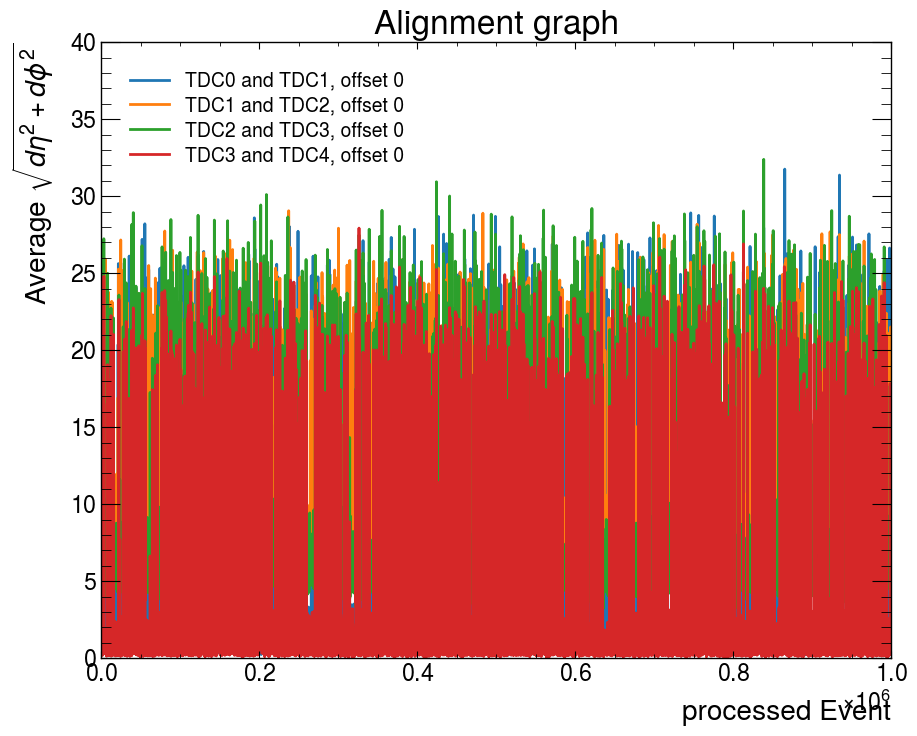

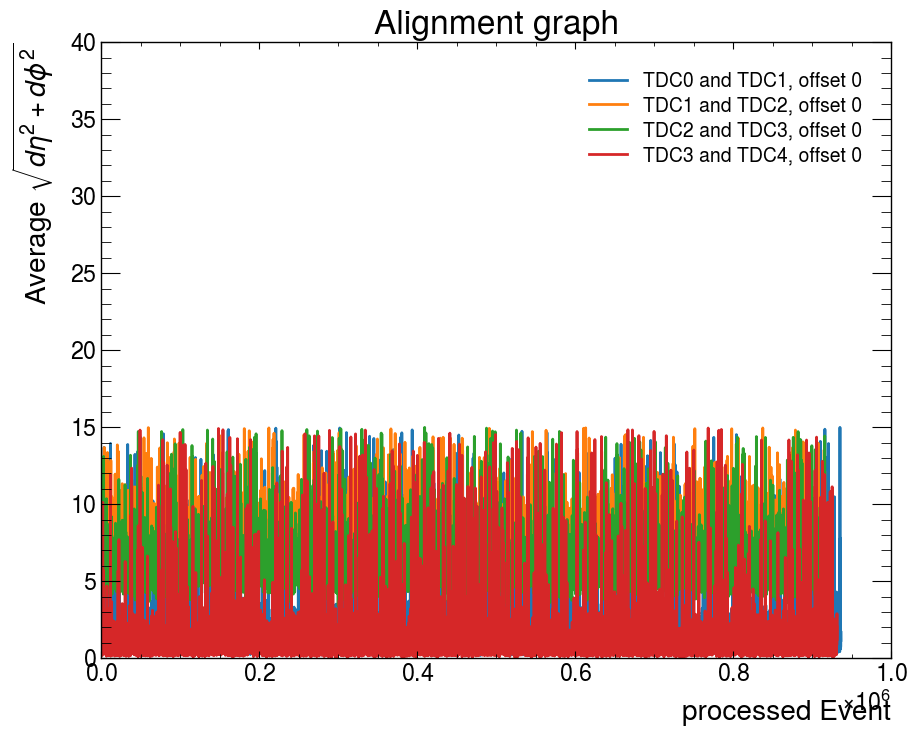

In [21]:
importlib.reload(rawFileReader)
interval = 100
file_path = '../Data/Fixed.raw'
fReader = rawFileReader.fileReader(file_path)
order = [[0,1], [1,2], [2,3], [3,4]]

rAligner = realigner(fReader= fReader, max_process_event=1000000, monitor_factor=10, order=order, dev_mode=True, window_size=10, record_inserted_events=True)
rAligner.get_aligned_events()
rAligner.plot_alignment_metric()
rAligner.plot_global_alignment_metric()
# rAligner.plotTDCTimeDiffs(showplot= False)
# rAligner.plot_tdc_state_metric()
# rAligner.plot_efficiency(text = 'Uncompensated_efficiency,  time_window = 10ns')


In [22]:
print(rAligner.event_hist)

[790, 793, 693, 796, 690]


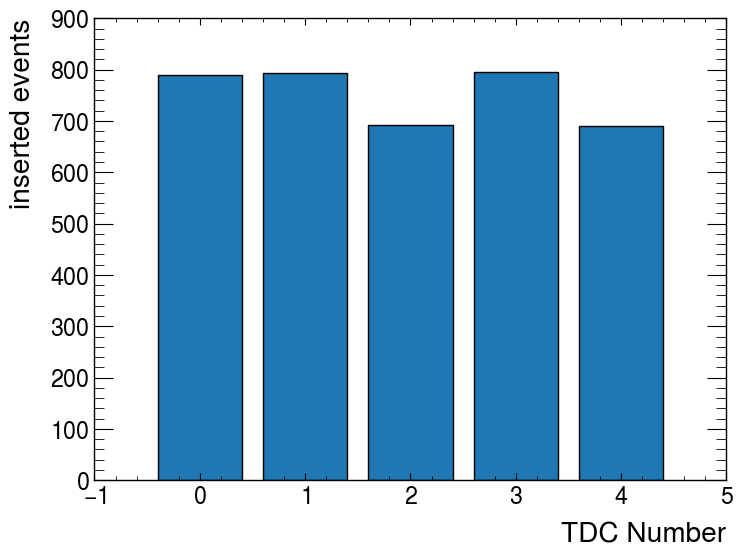

In [23]:
plt.bar(range(len(rAligner.event_hist)), rAligner.event_hist, edgecolor='black')
plt.xlabel('TDC Number')
plt.ylabel('inserted events')
plt.show()

New alignment, Event number 100, insertions [0, 2, 4, 7, 4], updates [-2, -2, -3, 0]
New alignment, Event number 400, insertions [0, 0, 0, 0, 5], updates [0, 0, 0, -5]
New alignment, Event number 20900, insertions [3, 0, 3, 3, 3], updates [3, -3, 0, 0]
New alignment, Event number 42000, insertions [0, 1, 0, 0, 0], updates [-1, 1, 0, 0]
New alignment, Event number 95100, insertions [1, 1, 1, 0, 1], updates [0, 0, 1, 0]
New alignment, Event number 95600, insertions [1, 1, 1, 0, 1], updates [0, 0, 1, 0]
tdc3 enters error state through metric
tdc3 enters nominal state through metric
event builder reloaded, proof [[], [], [], [], []]
New alignment, Event number 99100, insertions [12, 0, 3, 7, 8], updates [12, -3, -4, -5]
New alignment, Event number 111900, insertions [1, 1, 1, 0, 1], updates [0, 0, 1, 0]
New alignment, Event number 112000, insertions [0, 1, 1, 1, 0], updates [-1, 0, 0, 1]
New alignment, Event number 126200, insertions [0, 1, 1, 0, 1], updates [-1, 0, 1, 0]
New alignment, Ev

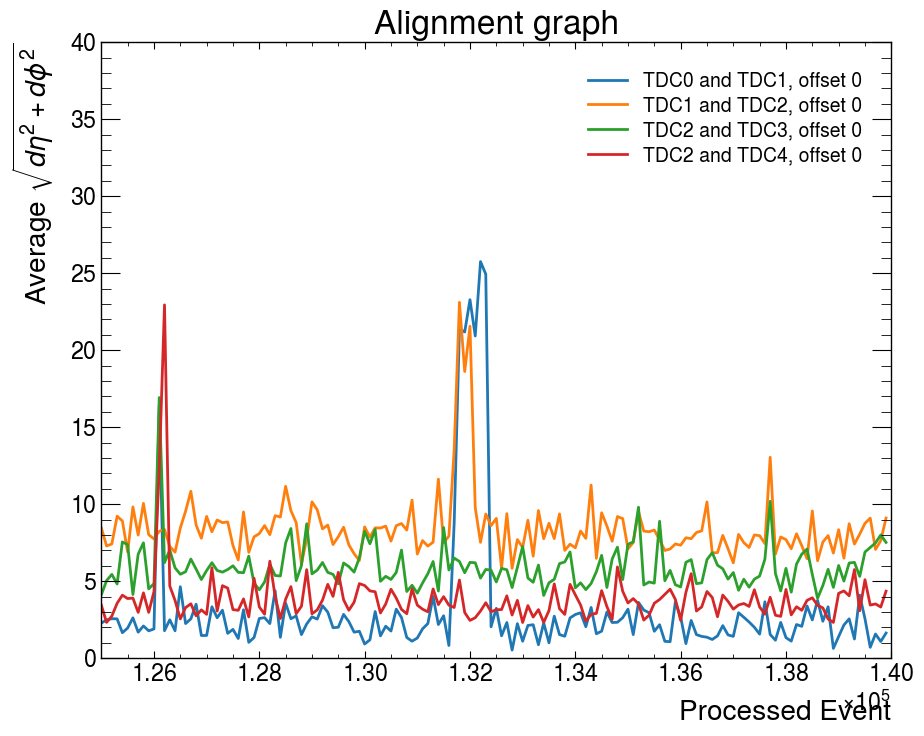

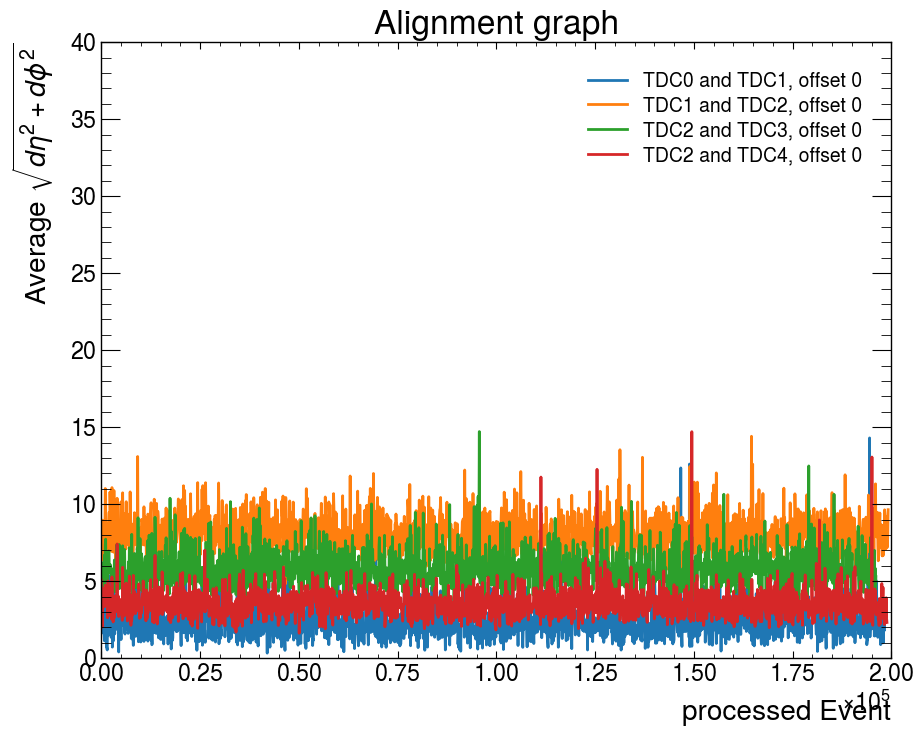

In [49]:
importlib.reload(rawFileReader)
interval = 100
file_path = '../Data/Old/Beam2.raw'
fReader = rawFileReader.fileReader(file_path)
order = [[0,1], [1,2], [2,3], [2,4]]

rAligner = realigner(fReader= fReader, max_process_event=200000, monitor_factor=10, order=order, dev_mode=True, window_size=10, record_inserted_events=True)
rAligner.get_aligned_events()
rAligner.plot_alignment_metric(plot_range=[125000,140000])
rAligner.plot_global_alignment_metric()
# rAligner.plotTDCTimeDiffs(showplot= False)
# rAligner.plot_tdc_state_metric()
# rAligner.plot_efficiency(text = 'Uncompensated_efficiency,  time_window = 10ns')


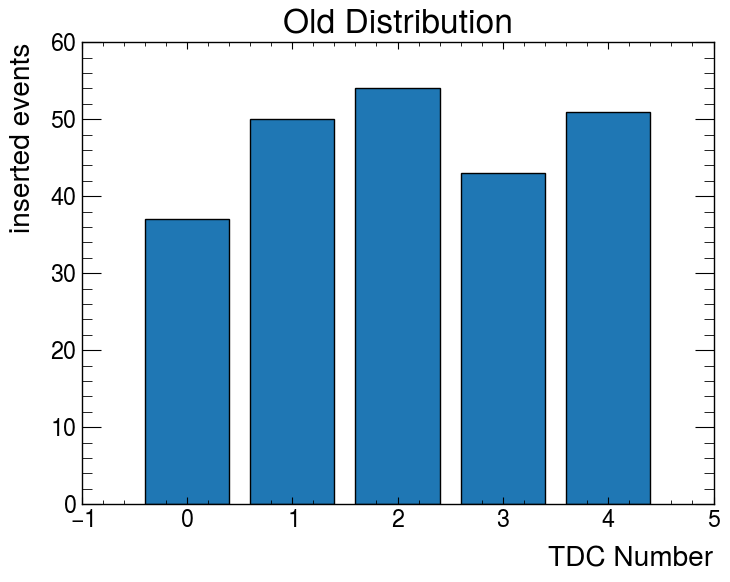

In [28]:
plt.bar(range(len(rAligner.event_hist)), rAligner.event_hist, edgecolor='black')
plt.title('Old Distribution')
plt.xlabel('TDC Number')
plt.ylabel('inserted events')
plt.show()